# This notebook seeks to Answer
* How do classifier (e.g.: linear probe) transfer between different types of attacks?

In [1]:
from pathlib import Path
import os
# Get the current working directory (where the notebook is)
notebook_dir = Path.cwd()

# Move up to the root directory (parent of 'notebooks')
project_root = notebook_dir.parent.parent
os.chdir(project_root)


In [2]:
import pandas as pd
import sys
import os
import numpy as np
from pathlib import Path

In [3]:
from analysis.unsupervised import *
from analysis.supervised import *

In [4]:
## Load rated dataset 
wild_jailbreak_path = project_root/ "datasets/latest/wildJailBreak_rated.pkl"

wei_gemma7bit = project_root / "datasets/latest/wei_three_new_rated_merged.pkl"

wei_llama8bit = project_root / "datasets/_meta-llamaLlama-3.1-8B-Instruct_prompt_res_activations_2911202410:07:48_rated.pkl"


path = [wild_jailbreak_path, wei_gemma7bit, wei_llama8bit][1]

df = pd.read_pickle(path)

path = str(path)

In [25]:
## CONFIG
model_names = [
    "gemma-7b-it",
    "Llama-3.1-8B-Instruct",
    "Llama-3.2-3b-Instruct",
]

# Determine the model name based on the file path
def get_model_name(path):
    for model_name in model_names:
        if model_name in str(path):
            return model_name
    return "gemma-7b-it"  # Default if no match is found

model_name = get_model_name(path)

layer=17
activation_column="prompt_res_activations"
num_samples = len(df)
dataset_name = "wildJailBreak" if "wildJailBreak" in str(path) else "wei_dataset"

In [7]:
rating_column = ["rating", "rating_output_text"][0]
# Calculate ASR for each jailbreak_prompt_name
asr_values = []

for jailbreak_prompt in df['jailbreak_prompt_name'].unique():
    # Calculate normalized value counts for each prompt
    ASR = df[df['jailbreak_prompt_name'] == jailbreak_prompt][rating_column].value_counts(normalize=True)
    if "Yes" in ASR:  # Only consider prompts with "Yes" success rates
        asr_values.append(ASR["Yes"])

# Calculate the 90th percentile cutoff
percentile = 50
percentile_cutoff = np.percentile(asr_values, percentile)
print(f"{percentile}th Percentile Cutoff for ASR: {percentile_cutoff}")

# Collect successful jailbreak_prompt_names above the 90th percentile
successful_jailbreaks = []

for jailbreak_prompt in df['jailbreak_prompt_name'].unique():
    ASR = df[df['jailbreak_prompt_name'] == jailbreak_prompt][rating_column].value_counts(normalize=True)
    # Check conditions: ASR["Yes"] exists and exceeds the 90th percentile
    if "Yes" in ASR and ASR["Yes"] > percentile_cutoff:
        successful_jailbreaks.append(jailbreak_prompt)

# Filter the dataframe to keep only rows matching the criteria or the 'original_prompt'
df = df[(df['jailbreak_prompt_name'].isin(successful_jailbreaks)) | (df['jailbreak_prompt_name'] == 'original_prompt')]

# Display the count of remaining jailbreak_prompt_name values
print(df["jailbreak_prompt_name"].value_counts())


50th Percentile Cutoff for ASR: 0.056666666666666664
jailbreak_prompt_name
original_prompt           600
combination_3             300
disemvowel                300
leetspeak                 300
gcg                       300
autodan                   300
wikipedia                 300
AIM                       300
prefix_injection_hello    300
style_injection_json      300
poems                     300
refusal_suppression       300
evil_confidant            300
prefix_injection          300
wikipedia_with_title      300
multi_shot_5              300
Name: count, dtype: int64


## Linear Probe

In [8]:
def extract_layer(row, layer):
    return row['prompt_res_activations'][layer][0].cpu().numpy().flatten()

In [10]:
# Add column that has 0 if "rating" is "No" and 1 if "rating" is "Yes"
df['rating_binary'] = df[rating_column].apply(lambda x: 0 if x == "No" else 1)

# Create new columns for each layer
df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)


In [11]:
results_df = probe_transfer(df, "logistic_regression", layer = layer)

results_df

rating_binary
0    26
1    26
Name: count, dtype: int64
rating_binary
0    23
1    23
Name: count, dtype: int64
rating_binary
1    21
0    21
Name: count, dtype: int64
rating_binary
0    48
1    48
Name: count, dtype: int64
rating_binary
0    31
1    31
Name: count, dtype: int64
rating_binary
0    69
1    69
Name: count, dtype: int64
rating_binary
1    21
0    21
Name: count, dtype: int64
rating_binary
1    101
0    101
Name: count, dtype: int64
rating_binary
1    30
0    30
Name: count, dtype: int64
rating_binary
1    51
0    51
Name: count, dtype: int64
rating_binary
1    23
0    23
Name: count, dtype: int64
rating_binary
1    19
0    19
Name: count, dtype: int64
rating_binary
0    76
1    76
Name: count, dtype: int64
rating_binary
1    53
0    53
Name: count, dtype: int64
rating_binary
1    58
0    58
Name: count, dtype: int64
rating_binary
1    51
0    51
Name: count, dtype: int64


,original_prompt,combination_3,disemvowel,leetspeak,gcg,autodan,wikipedia,AIM,prefix_injection_hello,style_injection_json,poems,refusal_suppression,evil_confidant,prefix_injection,wikipedia_with_title,multi_shot_5
original_prompt,1.0,0.6,0.333333,0.45,0.307692,0.571429,0.666667,0.585366,0.666667,0.52381,0.5,0.375,0.548387,0.545455,0.416667,0.619048
combination_3,0.727273,0.9,0.444444,0.3,0.538462,0.428571,0.555556,0.487805,0.583333,0.428571,0.6,0.25,0.516129,0.590909,0.5,0.52381
disemvowel,0.818182,0.5,0.333333,0.55,0.769231,0.535714,0.666667,0.560976,0.333333,0.47619,0.3,0.75,0.548387,0.818182,0.5,0.52381
leetspeak,0.636364,0.3,0.444444,0.4,0.307692,0.571429,0.777778,0.512195,0.5,0.666667,0.5,0.5,0.677419,0.363636,0.666667,0.52381
gcg,0.727273,0.4,0.444444,0.5,0.538462,0.392857,0.555556,0.439024,0.666667,0.666667,0.5,0.5,0.548387,0.590909,0.666667,0.428571
autodan,0.363636,0.4,0.555556,0.65,0.692308,0.75,0.666667,0.609756,0.75,0.47619,0.3,0.75,0.612903,0.681818,0.583333,0.47619
wikipedia,0.818182,0.4,0.444444,0.65,0.692308,0.571429,1.0,0.585366,0.583333,0.52381,0.3,0.25,0.612903,0.5,0.666667,0.666667
AIM,0.454545,0.6,0.444444,0.5,0.769231,0.642857,0.555556,0.780488,0.333333,0.333333,0.5,0.625,0.354839,0.681818,0.625,0.428571
prefix_injection_hello,0.545455,0.6,0.555556,0.45,0.461538,0.5,0.555556,0.634146,0.833333,0.380952,0.7,0.375,0.451613,0.772727,0.416667,0.47619
style_injection_json,0.727273,0.5,0.222222,0.6,0.615385,0.535714,0.555556,0.707317,0.75,0.857143,0.8,0.125,0.548387,0.863636,0.75,0.571429


In [12]:
results_df.describe()

,original_prompt,combination_3,disemvowel,leetspeak,gcg,autodan,wikipedia,AIM,prefix_injection_hello,style_injection_json,poems,refusal_suppression,evil_confidant,prefix_injection,wikipedia_with_title,multi_shot_5
count,16.000000,16.0,16.000000,16.0,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.0,16.000,16.000000,16.000000,16.0,16.00000
unique,7.000000,6.0,5.000000,8.0,7.000000,8.000000,6.000000,10.000000,7.000000,9.000000,6.0,7.000,10.000000,11.000000,9.0,8.00000
top,0.727273,0.6,0.444444,0.5,0.538462,0.571429,0.555556,0.585366,0.583333,0.666667,0.5,0.625,0.548387,0.545455,0.5,0.52381
freq,3.000000,6.0,9.000000,4.0,3.000000,3.000000,7.000000,5.000000,3.000000,3.000000,6.0,4.000,5.000000,2.000000,4.0,4.00000


In [13]:
results_df.mean()

original_prompt           0.630682
combination_3              0.53125
disemvowel                0.465278
leetspeak                 0.509375
gcg                       0.548077
autodan                   0.555804
wikipedia                 0.611111
AIM                       0.592988
prefix_injection_hello    0.552083
style_injection_json      0.529762
poems                       0.5125
refusal_suppression        0.53125
evil_confidant            0.570565
prefix_injection          0.616477
wikipedia_with_title      0.575521
multi_shot_5              0.520833
dtype: object

In [14]:
results_df.mean(axis=1)


original_prompt           0.544345
combination_3             0.523429
disemvowel                  0.5615
leetspeak                 0.521756
gcg                       0.535343
autodan                   0.582397
wikipedia                 0.579069
AIM                       0.539314
prefix_injection_hello    0.544296
style_injection_json      0.608066
poems                     0.510074
refusal_suppression       0.524299
evil_confidant            0.580626
prefix_injection          0.564531
wikipedia_with_title      0.626641
multi_shot_5              0.507868
dtype: object

In [15]:
results_df.mean(axis=0)

original_prompt           0.630682
combination_3              0.53125
disemvowel                0.465278
leetspeak                 0.509375
gcg                       0.548077
autodan                   0.555804
wikipedia                 0.611111
AIM                       0.592988
prefix_injection_hello    0.552083
style_injection_json      0.529762
poems                       0.5125
refusal_suppression        0.53125
evil_confidant            0.570565
prefix_injection          0.616477
wikipedia_with_title      0.575521
multi_shot_5              0.520833
dtype: object

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:535: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_df = results_df.fillna(0)


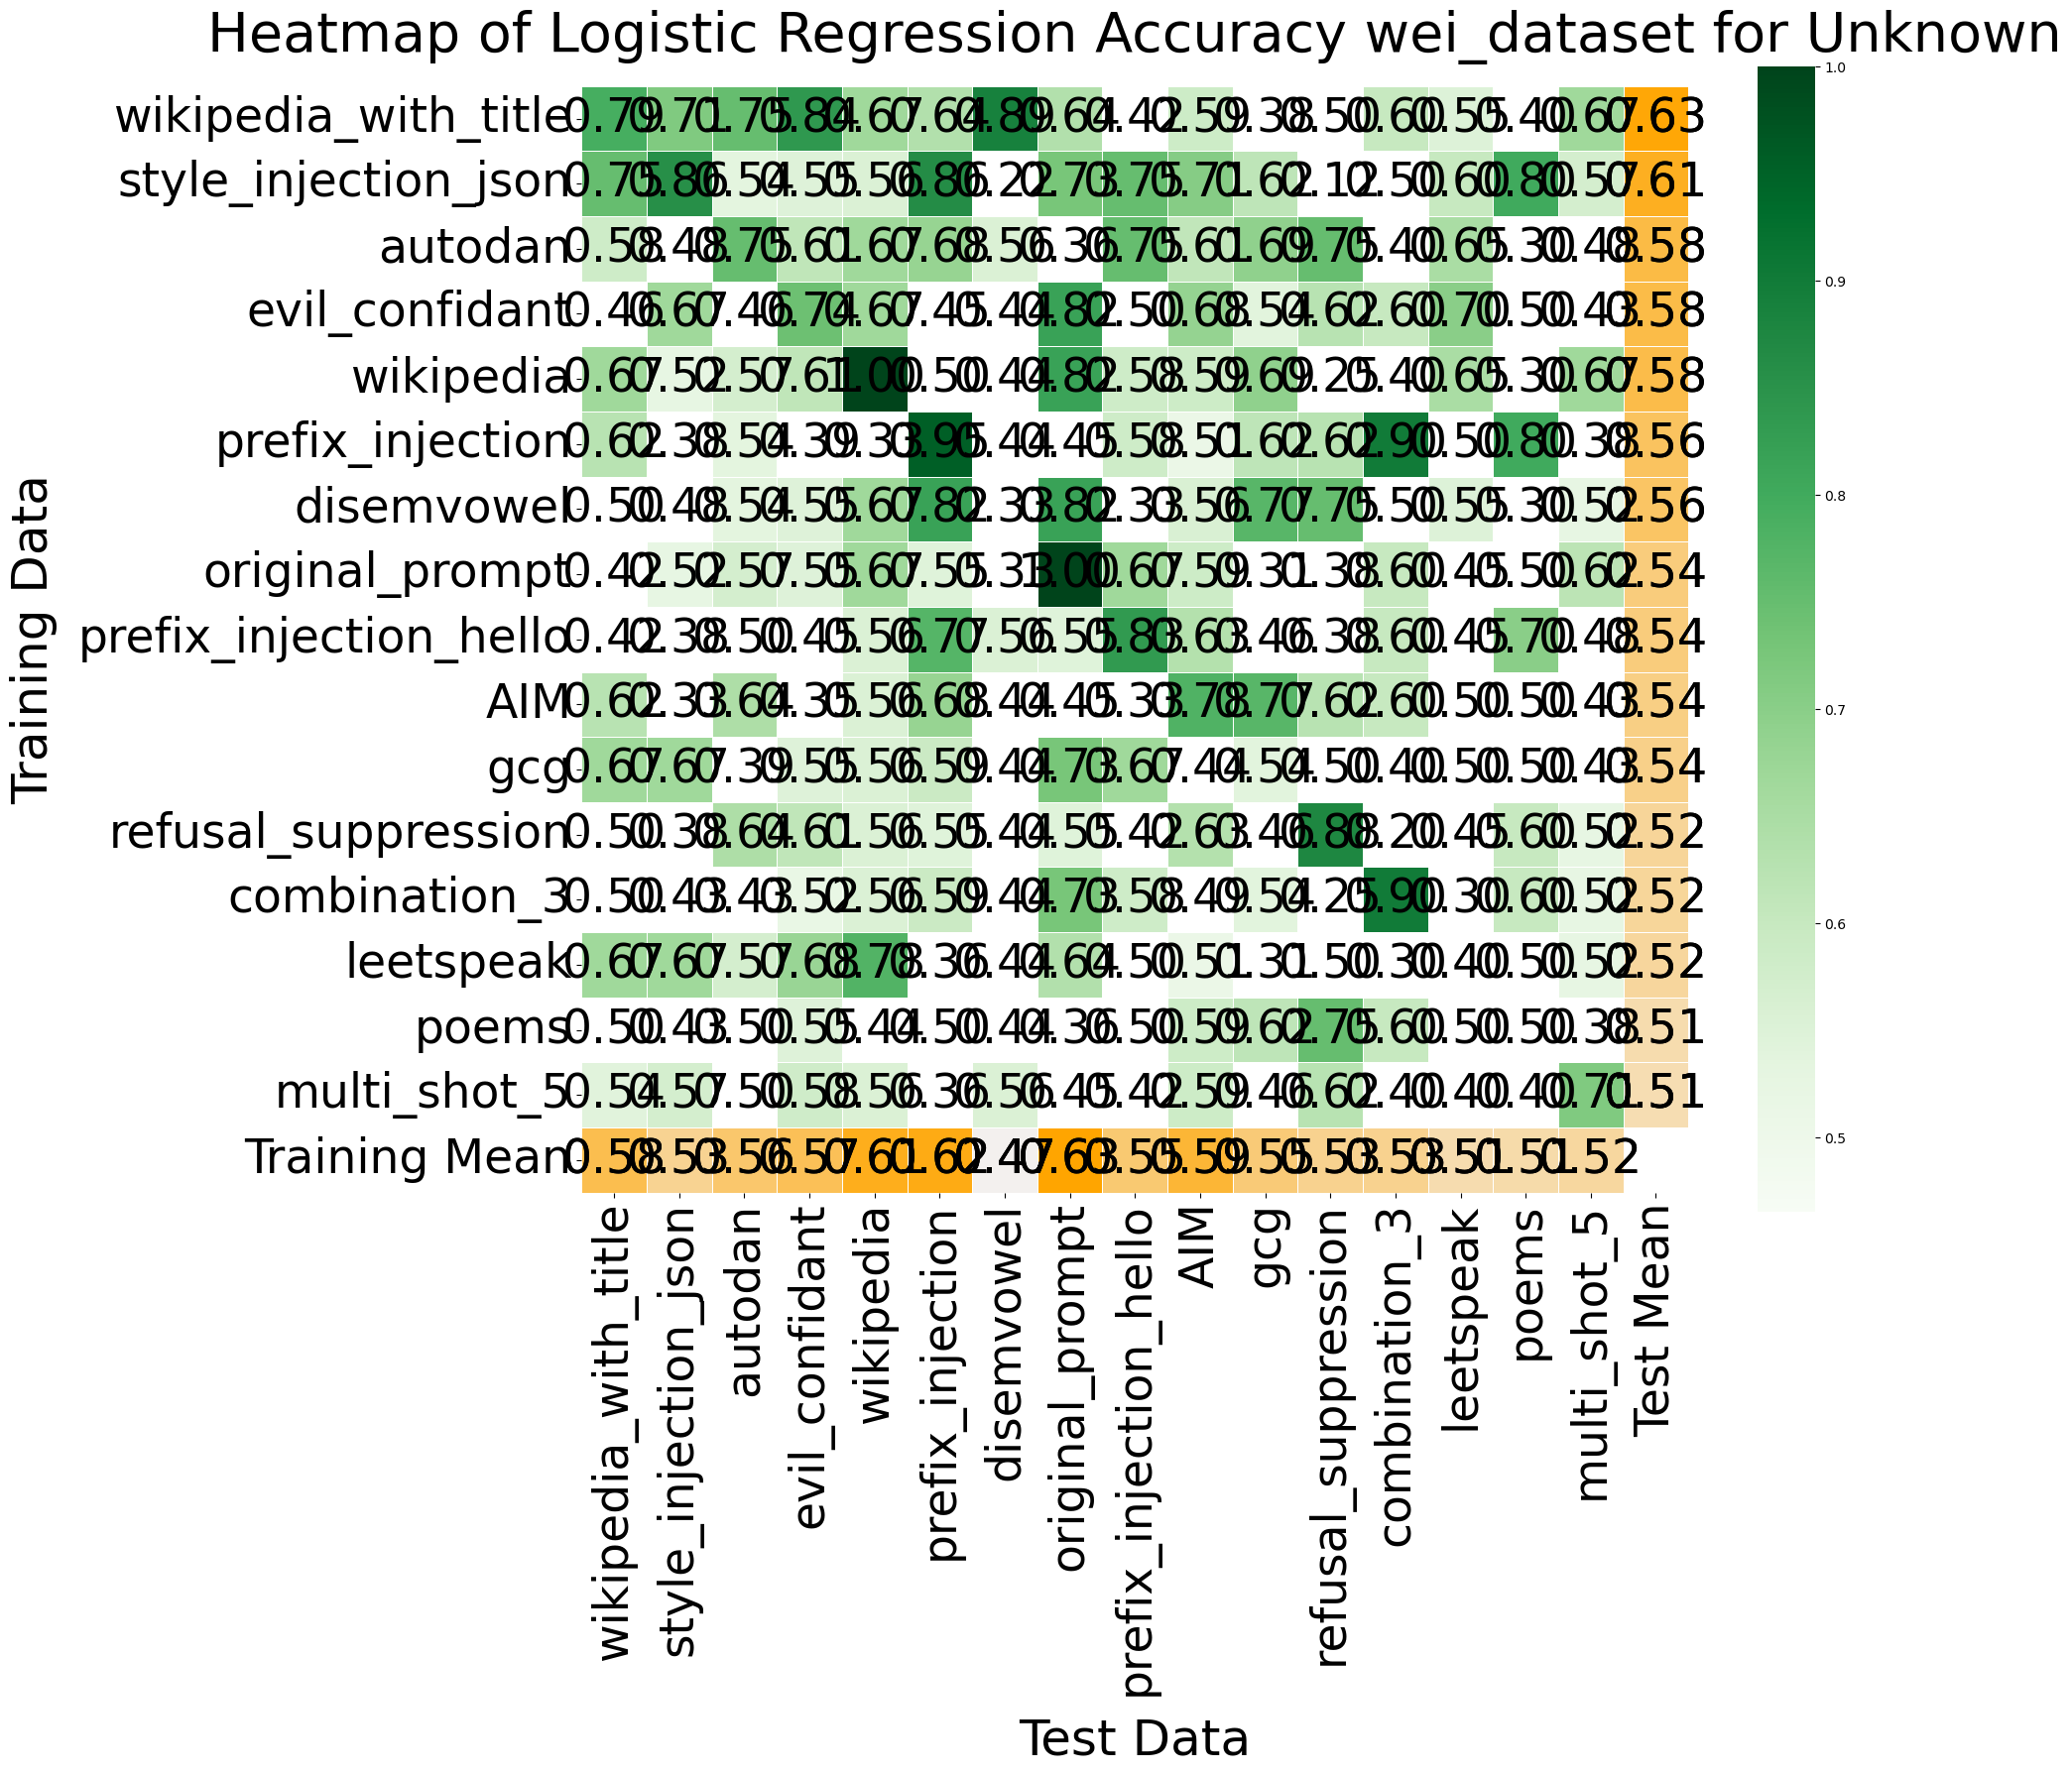

In [16]:
transfer_heatmap(results_df= results_df, dataset_name=dataset_name, model_name = model_name, probe_type = "Logistic Regression")


In [ ]:
df[df["jailbreak_prompt_name"] == "AIM"]["rating_output_text"].value_counts()

## Transfer with Holdout

In [ ]:
holdout_df = transfer_with_holdout(df = df, probe_type = "logistic_regression", layer = layer)
holdout_df
  

In [19]:
holdout_df = transfer_with_holdout_with_errors(df = df, probe_type = "logistic_regression", layer = layer)


Holdout:  original_prompt
before balancing
rating_binary
0    3529
1     971
Name: count, dtype: int64
after balancing
rating_binary
1    971
0    971
Name: count, dtype: int64


0.9517063747585319
0.7969151670951157
Test Accuracy: 0.7969151670951157, SE: 0.009128936337572289
Holdout:  combination_3
before balancing
rating_binary
0    3826
1     974
Name: count, dtype: int64
after balancing
rating_binary
1    974
0    974
Name: count, dtype: int64
0.9621309370988447
0.823076923076923
Test Accuracy: 0.823076923076923, SE: 0.008646054689368694
Holdout:  disemvowel
before balancing
rating_binary
0    3824
1     976
Name: count, dtype: int64
after balancing
rating_binary
0    976
1    976
Name: count, dtype: int64
0.9442664958360025
0.8465473145780051
Test Accuracy: 0.8465473145780051, SE: 0.008157798201431138
Holdout:  leetspeak
before balancing
rating_binary
0    3851
1     949
Name: count, dtype: int64
after balancing
rating_binary
1    949
0    949
Name: count, dtype: int64
0.9545454545454546
0.8473684210526315
Test Accuracy: 0.8473684210526315, SE: 0.008254869880350523
Holdout:  gcg
before balancing
rating_binary
0    3834
1     966
Name: count, dtype: int64
a

In [20]:
holdout_df

,Train Set,Test Set (Holdout),Test Set SE,Test Size,Test Set
original_prompt,0.951706,0.796915,0.009129,1942,0.951706
combination_3,0.962131,0.823077,0.008646,1948,0.962131
disemvowel,0.944266,0.846547,0.008158,1952,0.944266
leetspeak,0.954545,0.847368,0.008255,1898,0.954545
gcg,0.952751,0.824289,0.008658,1932,0.952751
autodan,0.948113,0.814516,0.009022,1856,0.948113
wikipedia,0.949391,0.790281,0.009214,1952,0.949391
AIM,0.964734,0.7875,0.01024,1596,0.964734
prefix_injection_hello,0.956044,0.819121,0.008753,1934,0.956044
style_injection_json,0.953073,0.810026,0.009019,1892,0.953073


In [21]:
mean_transfer = round(holdout_df["Test Set (Holdout)"].mean(),2)

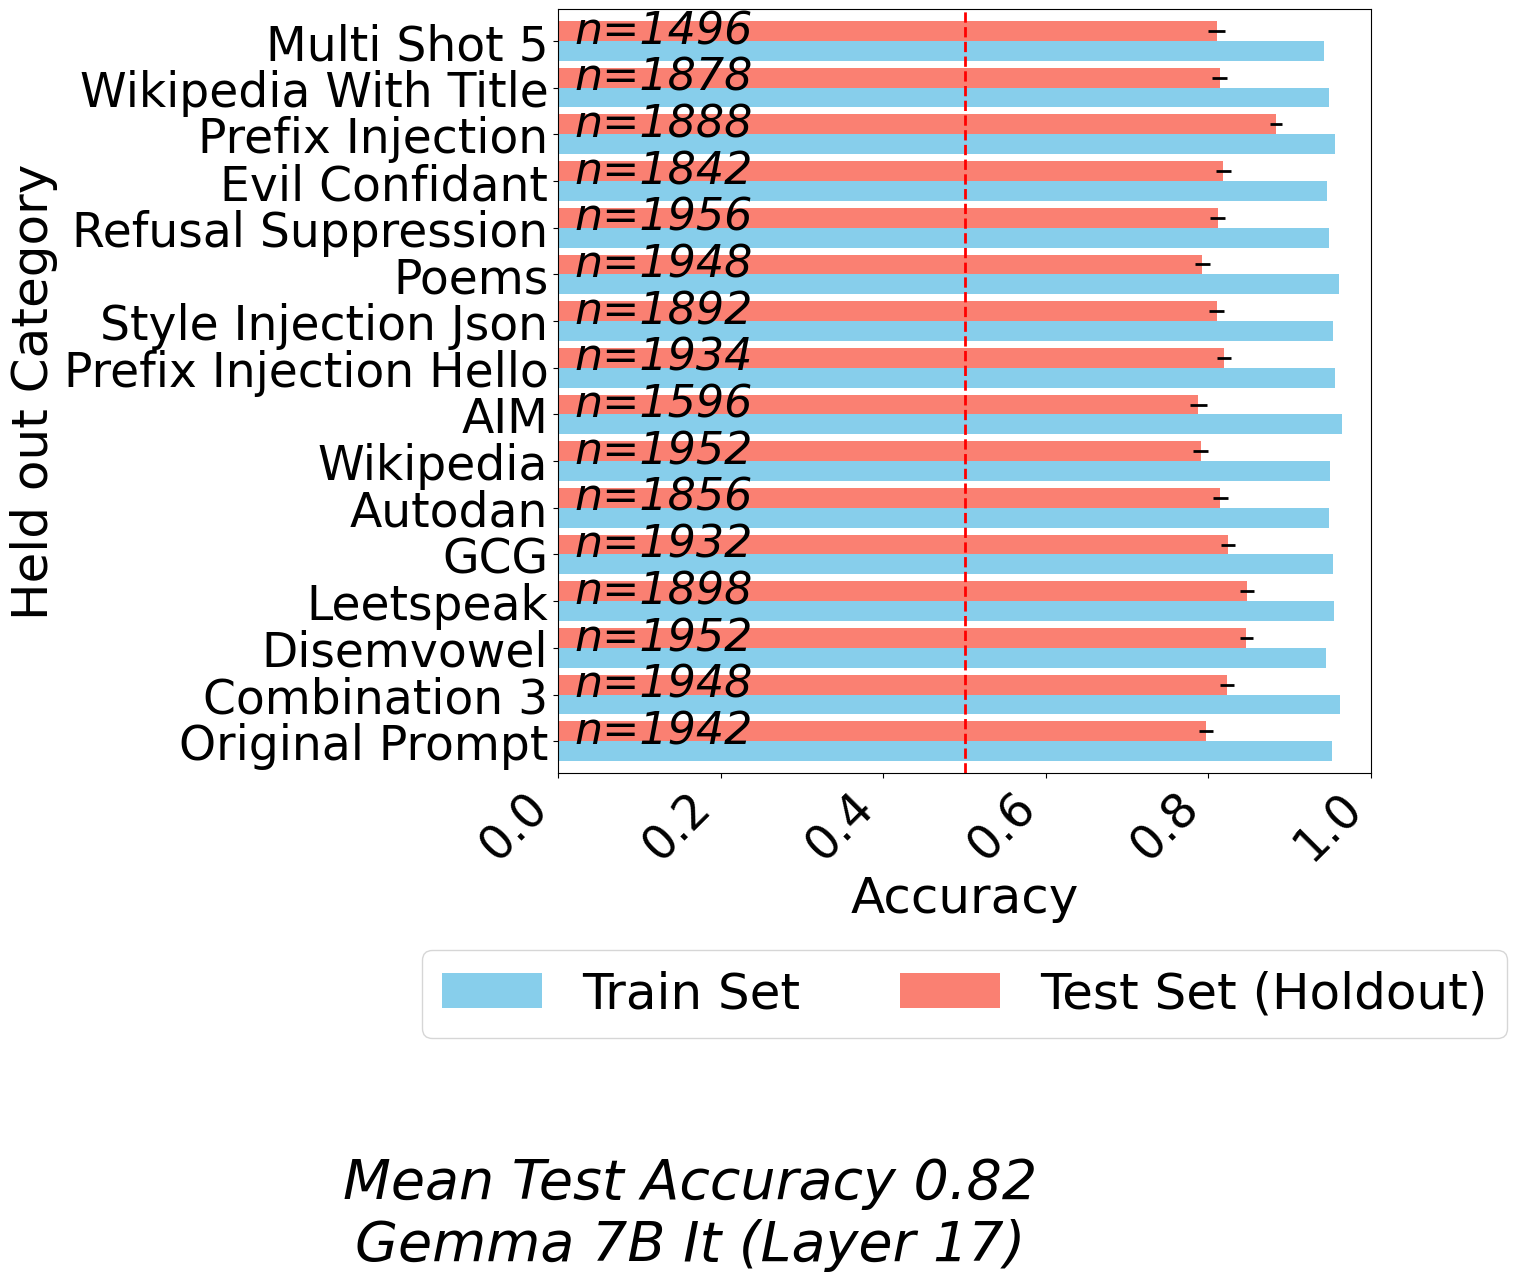

In [26]:
holdout_transfer_graph(holdout_df= holdout_df, dataset_name=dataset_name, model_name = model_name, layer = layer, probe_type = "Linear", mean_tranfer_score=mean_transfer)

## MLP Probe

In [27]:
from analysis.supervised import *

In [ ]:
results_df = probe_transfer(df = df, probe_type = "MLP", layer = layer)


results_df

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:535: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_df = results_df.fillna(0)


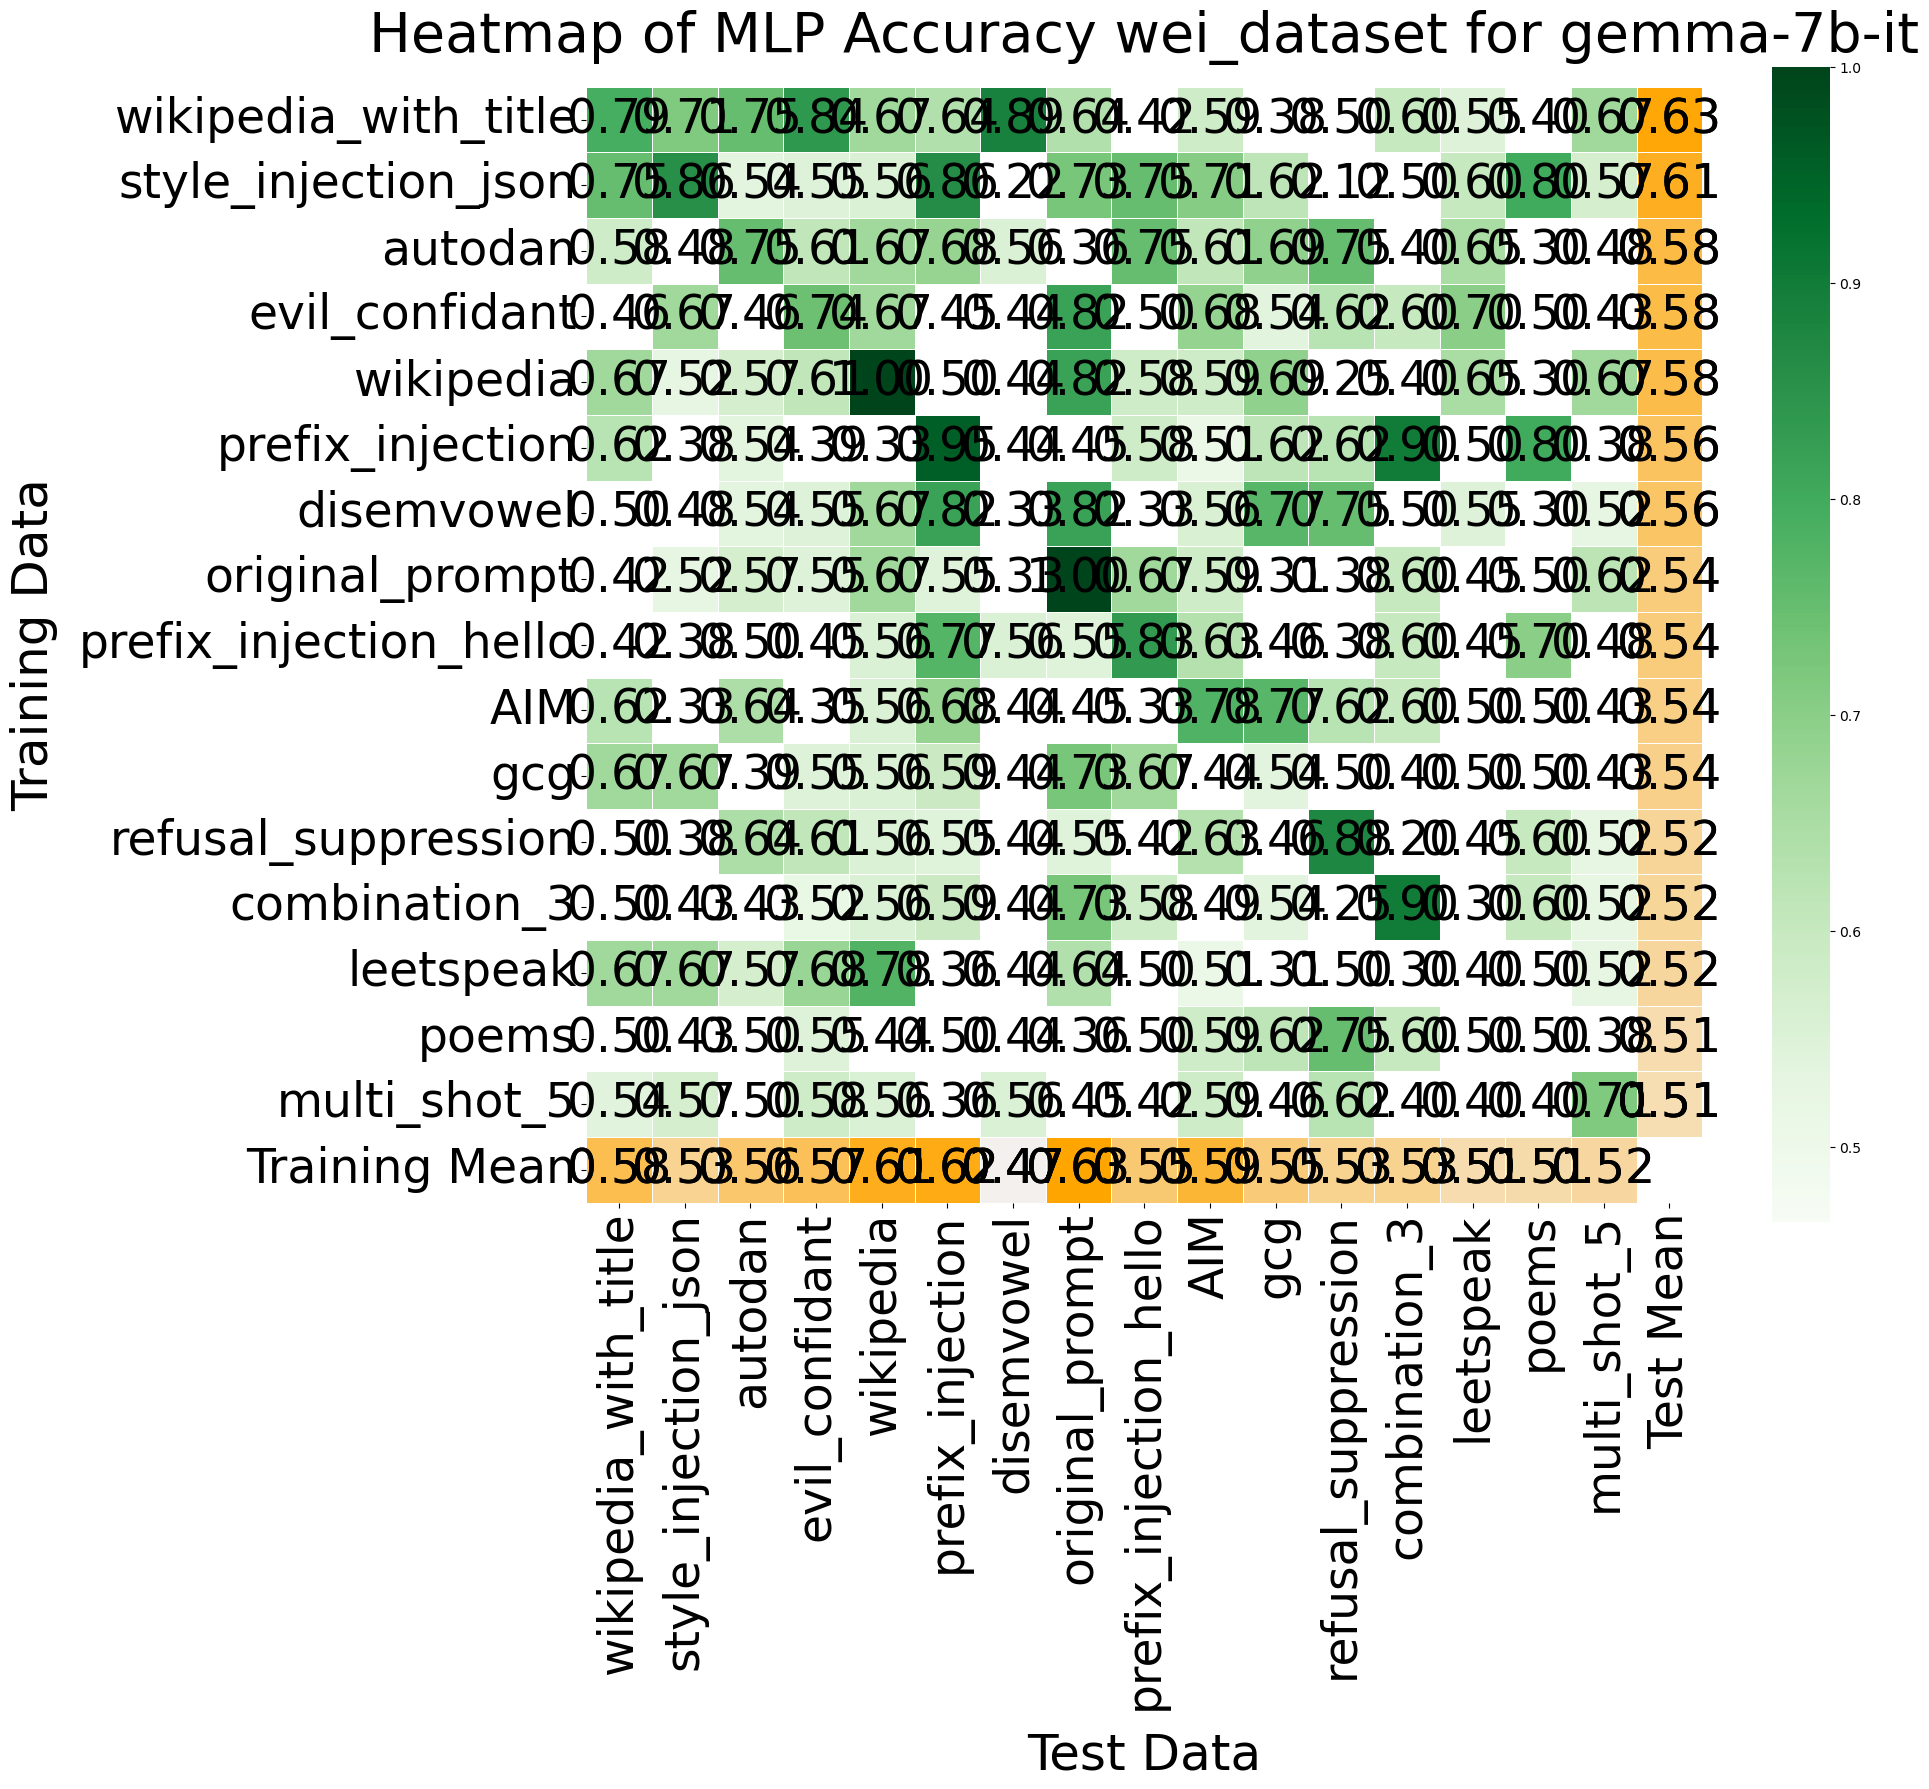

In [28]:
plot = transfer_heatmap(results_df= results_df, dataset_name=dataset_name, model_name = model_name, probe_type = "MLP")

In [29]:
holdout_df = transfer_with_holdout_with_errors(df = df, probe_type = "MLP", layer = layer)


Holdout:  original_prompt
before balancing
rating_binary
0    3529
1     971
Name: count, dtype: int64
after balancing
rating_binary
0    971
1    971
Name: count, dtype: int64
0.7701223438506117
0.699228791773779
Test Accuracy: 0.699228791773779, SE: 0.010406463583232554
Holdout:  combination_3
before balancing
rating_binary
0    3826
1     974
Name: count, dtype: int64
after balancing
rating_binary
0    974
1    974
Name: count, dtype: int64
0.772785622593068
0.6743589743589744
Test Accuracy: 0.6743589743589744, SE: 0.010617460437889423
Holdout:  disemvowel
before balancing
rating_binary
0    3824
1     976
Name: count, dtype: int64
after balancing
rating_binary
0    976
1    976
Name: count, dtype: int64
0.8526585522101218
0.7928388746803069
Test Accuracy: 0.7928388746803069, SE: 0.009172900703349514
Holdout:  leetspeak
before balancing
rating_binary
0    3851
1     949
Name: count, dtype: int64
after balancing
rating_binary
0    949
1    949
Name: count, dtype: int64


0.7470355731225297
0.6815789473684211
Test Accuracy: 0.6815789473684211, SE: 0.010693278219978732
Holdout:  gcg
before balancing
rating_binary
0    3834
1     966
Name: count, dtype: int64
after balancing
rating_binary
1    966
0    966
Name: count, dtype: int64
0.8673139158576052
0.7286821705426356
Test Accuracy: 0.7286821705426356, SE: 0.010115903496918061
Holdout:  autodan
before balancing
rating_binary
0    3872
1     928
Name: count, dtype: int64
after balancing
rating_binary
0    928
1    928
Name: count, dtype: int64
0.8369272237196765
0.7741935483870968
Test Accuracy: 0.7741935483870968, SE: 0.009705188190553474
Holdout:  wikipedia
before balancing
rating_binary
0    3824
1     976
Name: count, dtype: int64
after balancing
rating_binary
1    976
0    976
Name: count, dtype: int64
0.8174247277386291
0.7186700767263428
Test Accuracy: 0.7186700767263428, SE: 0.010177306137552654
Holdout:  AIM
before balancing
rating_binary
0    4002
1     798
Name: count, dtype: int64
after balanc

In [30]:
holdout_df

,Train Set,Test Set (Holdout),Test Set SE,Test Size,Test Set
original_prompt,0.770122,0.699229,0.010406,1942,0.770122
combination_3,0.772786,0.674359,0.010617,1948,0.772786
disemvowel,0.852659,0.792839,0.009173,1952,0.852659
leetspeak,0.747036,0.681579,0.010693,1898,0.747036
gcg,0.867314,0.728682,0.010116,1932,0.867314
autodan,0.836927,0.774194,0.009705,1856,0.836927
wikipedia,0.817425,0.71867,0.010177,1952,0.817425
AIM,0.808777,0.73125,0.011097,1596,0.808777
prefix_injection_hello,0.816419,0.741602,0.009954,1934,0.816419
style_injection_json,0.860542,0.759894,0.00982,1892,0.860542


In [31]:
# get mean of holdout_df["Test Set (Holdout)"]
mean_transfer = round(holdout_df["Test Set (Holdout)"].mean(),2)

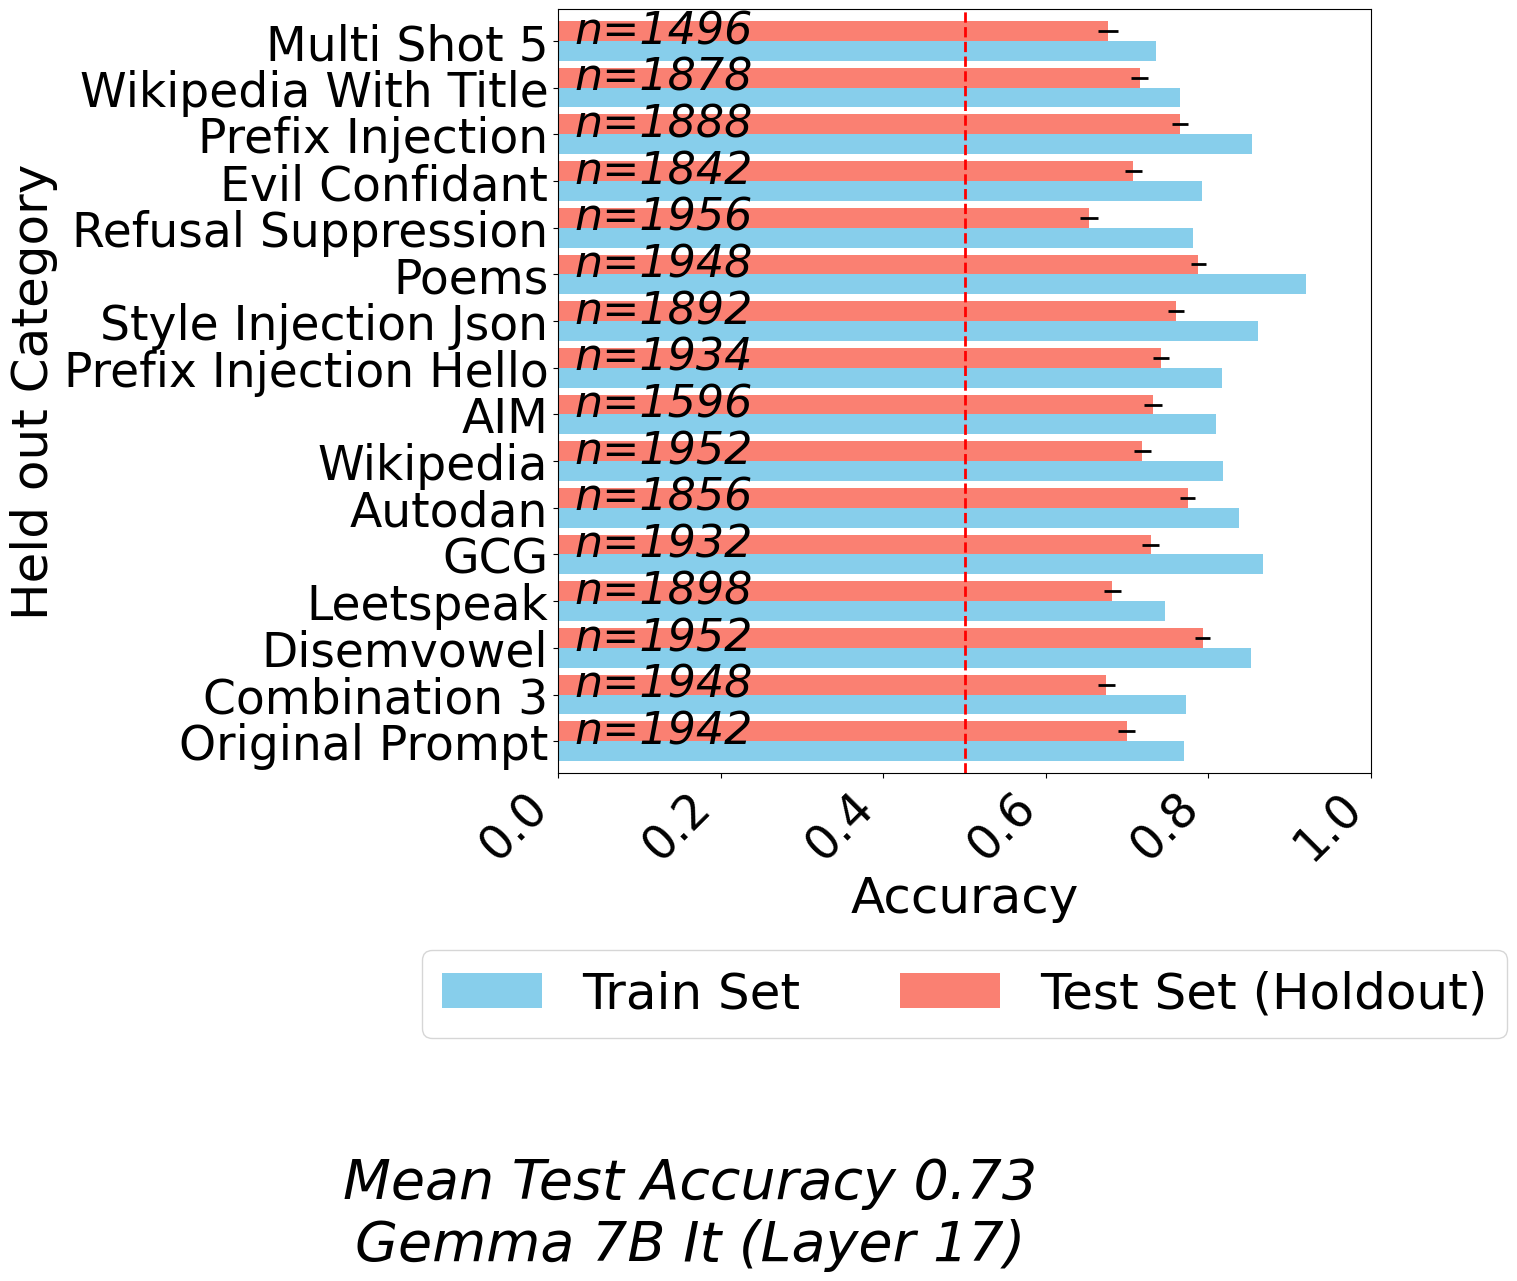

In [32]:
plot = holdout_transfer_graph(holdout_df= holdout_df, dataset_name=dataset_name, model_name = model_name, layer = layer, probe_type = "MLP", mean_tranfer_score= mean_transfer)

## 